In [2]:
import numpy as np
import pandas as pd
import healpy as hp
import os
from astropy.coordinates import SkyCoord
from astropy import units as u
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [14]:
def get_prm(prm, s, w='\d'):
    import re
    return re.search(prm + r'(' + w + '+)', s)[0][len(prm):]

east_val = [38, 6]
west_val = [41, 9]
east = [0,  1,  2,  3,  4,  5,  6,  7, 16, 17, 20, 21, 22, 23, 24, 26, 27,
       32, 33, 34, 35, 36, 37, 38, 39]

def radec2pix(ra, dec, nside):
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    import healpy as hp
    import numpy as np

    sc = SkyCoord(ra=np.array(ra)*u.degree, dec=np.array(dec)*u.degree, frame='icrs')
    return hp.ang2pix(nside, sc.galactic.l.degree, sc.galactic.b.degree, 
                                  nest=True, lonlat=True)
def colors_iterator():
    c = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'tab:blue', 'tab:orange', 'tab:green',
            'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive']

    while True:
        yield c[0]
        c = c[1:]
        
def calc_error(det_cat, true_cat, shift=15/60, match_dist=5/60, n_try=20, seed=0):
    import numpy as np
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    
    error = []
    np.random.seed(seed)
    for _ in range(n_try):
        det_sc = SkyCoord(ra=np.array(det_cat['RA']) * u.degree, 
                          dec=np.array(det_cat['DEC']) * u.degree, frame='icrs')
        angles = np.random.randint(0, 360, len(det_cat))
        det_sc = det_sc.directional_offset_by(angles*u.degree, shift)

        true_sc = SkyCoord(ra=np.array(true_cat['RA']) * u.degree, 
                           dec=np.array(true_cat['DEC']) * u.degree, frame='icrs')
        _, d2d, _ = det_sc.match_to_catalog_sky(true_sc)
        c_error = np.count_nonzero(d2d.degree < match_dist)
        error.append(c_error)
    error = np.array(error)
    return error.mean(), error.std() / np.sqrt(n_try - 1)



In [4]:
def stat_orig_cats_simple(det_cats_dict, big_pix=None, true_cats_dir='./true_clusters/', match_dist=5/60, read_det_files=True, 
                         excl_cats=[], errors=None):
    import os
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    import numpy as np
    import pandas as pd
    
    def cut_by_pix(cat, big_pix):
        pix = radec2pix(cat['RA'], cat['DEC'], 2)
        cat = cat[np.in1d(pix, big_pix)]
        cat.index = np.arange(len(cat))
        return cat
    
    def get_error(errors, cat_name, prm):
        return errors[cats_name][errors.index >= prm].sum()
    
    true_cats_files = next(os.walk(true_cats_dir))[-1]
    true_cats_files = [os.path.join(true_cats_dir, file) for file in true_cats_files]
    
    true_cats = {os.path.splitext(os.path.basename(file))[0] : pd.read_csv(file) for file in true_cats_files}
    true_cats = {tr_cat_name : true_cats[tr_cat_name] for tr_cat_name in true_cats if not (tr_cat_name in excl_cats)}
    det_cats = det_cats_dict
    if read_det_files:
        det_cats = {name : 
                pd.read_csv(det_cats_dict[name]) for name in det_cats_dict}
    
    recall_df = []
    if not (big_pix is None):
        for tr_name in true_cats:
            true_cats[tr_name] = cut_by_pix(true_cats[tr_name], big_pix)
        for name in det_cats:
            det_cats[name] = cut_by_pix(det_cats[name], big_pix)
    
    for name in det_cats:
        df = det_cats[name]
        df = df[df['status'] != 'fn']
        df.index = np.arange(len(df))
        df['found'] = False
        det_cats[name] = df
        
    
    for det_name in det_cats:
        det = det_cats[det_name]
        line_r = {}

        det_sc = SkyCoord(ra=np.array(det['RA'])*u.degree, 
                      dec=np.array(det['DEC'])*u.degree, frame='icrs') 

        for tr_name in true_cats: 
            tr = true_cats[tr_name]
            tr_sc = SkyCoord(ra=np.array(tr['RA'])*u.degree, 
                          dec=np.array(tr['DEC'])*u.degree, frame='icrs')
            
            idx, d2d, _ = tr_sc.match_to_catalog_sky(det_sc)
            matched = d2d.degree <= match_dist
            det.loc[idx[matched], 'found'] = True
            n_matched = np.count_nonzero(matched)
            if not (errors is None) and (tr_name in list(errors)):
                n_matched *= 1 - get_error(errors, tr_name, det_name)
            line_r[tr_name] =  n_matched / len(tr)
                
            
        #line_r['precision'] = 1 - np.count_nonzero(det['status'] == 'fp') / len(det)
        line_r['precision'] = np.count_nonzero(det['found']) / len(det)
        line_r['all'] = len(det)
        recall_df.append(pd.DataFrame(line_r, index=[det_name]))
    
    recall_df = pd.concat(recall_df)
    return recall_df


In [5]:
dirname = './all_found4/'
files = next(os.walk(dirname))[-1]
cat_d = {int(get_prm('ep', s)) : os.path.join(dirname, s) for s in files}
recall_df = stat_orig_cats_simple(cat_d, big_pix=[38])
recall_df = recall_df.sort_index()
recall_df.index.name='epoch'
recall_df.to_csv('./all_found4_recall.csv')

In [6]:
recall_df = stat_orig_cats_simple(cat_d, big_pix=[38], excl_cats=['eRosita'])
recall_df = recall_df.sort_index()
recall_df.index.name='epoch'
recall_df.to_csv('./all_found4_recall_no_erosita.csv')

In [7]:
def cut_max_pred(cat, max_pred):
    df = cat.copy()
    df = df[df['max_pred'] >= max_pred]
    df.index = np.arange(len(df))
    return df

In [17]:
det_cat = pd.read_csv('./full_pz_all_found34_thr0.1_step8_no_fn.csv')
cat_d = {max_pred_prm : cut_max_pred(det_cat, max_pred_prm) for max_pred_prm in np.arange(0.1, 1, 0.05)}
recall_df = stat_orig_cats_simple(cat_d, big_pix=east_val, read_det_files=False)
recall_df = recall_df.sort_index()
recall_df.index.name='max_pred'
recall_df.to_csv('./all_found34_recall_max_pred_pixe.csv')

,planck_z,MCXC,eRosita,ACT,Abell,precision,all
max_pred,,,,,,,
0.10,0.977778,0.423077,0.977778,0.213740,0.267658,0.165882,850
0.15,0.977778,0.400000,0.977778,0.198473,0.256506,0.202723,661
0.20,0.955556,0.384615,0.955556,0.190840,0.245353,0.231330,549
0.25,0.944444,0.384615,0.944444,0.175573,0.234201,0.265217,460
0.30,0.944444,0.384615,0.944444,0.175573,0.223048,0.310705,383
0.35,0.922222,0.376923,0.922222,0.160305,0.211896,0.346875,320
0.40,0.922222,0.376923,0.922222,0.152672,0.208178,0.392086,278
0.45,0.922222,0.369231,0.922222,0.152672,0.204461,0.451477,237
0.50,0.900000,0.346154,0.900000,0.129771,0.193309,0.483092,207


In [2]:
dirname = './true_clusters/'
true_cats = next(os.walk(dirname))[-1]
true_cats = {os.path.splitext(os.path.basename(s))[0] : os.path.join(dirname, s) for s in true_cats}
det_cat = './full_pz_all_found34_thr0.1_step8_no_fn.csv'

In [4]:
def make_histogram(ax, counts_list, bins, label_list=None, coef_list=None, log=True):
    if coef_list is None:
        coef_list = [1] * len(counts_list)
    if label_list is None:
        label_list = [''] * len(counts_list)
    
    ci = colors_iterator()
    for i, counts in enumerate(counts_list):
         ax.hist(bins[:-1], bins, weights=counts * coef_list[i], 
                  histtype='step', log=log, label=label_list[i], color=next(ci))
    ax.legend()

In [5]:
class Counts_cat:
    def __init__(self, name, found, error, alls, found_coef):
        self.name = name
        self.found = found
        self.error = error
        self.alls = alls
        self.found_coef = found_coef
    
    def err_ratio(self):
        return np.nan_to_num(self.error / self.found)
    def precision(self):
        return np.nan_to_num(self.found * self.found_coef / self.alls)
    def corr_precision(self):
        return (1 - self.err_ratio()) * self.precision()

In [6]:
def found_all_error_calculated(det_cat, true_cat, small_rads=[0, 400], big_rads=[1000, 1500], n_bins=20, func_cat=None,
                              with_tqdm=False, add_one_bin=False, cat_name=''):
    
    def func(angle1, angle2, det_cat, true_cat):
        colored = []
        tr = SkyCoord(ra=np.array(true_cat['RA'])*u.degree, dec=np.array(true_cat['DEC'])*u.degree, frame='icrs')
        
        iterator = range(len(det_cat))
        if with_tqdm:
            iterator = tqdm(iterator)

        for i in iterator:
            det = SkyCoord(ra=det_cat.loc[i, 'RA']*u.degree, dec=det_cat.loc[i, 'DEC']*u.degree, frame='icrs')
            sep = tr.separation(det).degree

            count = np.count_nonzero(np.logical_and(angle1/3600 <= sep, sep < angle2/3600))
            colored.extend(count * [det_cat.loc[i, 'max_pred']])

        return colored
    
    def square(rads):
        return np.pi * (rads[1] ** 2 - rads[0] ** 2)
    
    if not (func_cat is None):
        det_cat = func_cat(det_cat)
        true_cat = func_cat(true_cat)
    
    found = func(*small_rads, det_cat, true_cat)
    error = func(*big_rads, det_cat, true_cat)
    
    small_sq = square(small_rads)
    big_sq = square(big_rads)
    
    bins = np.arange(0, 1 + 1/n_bins, 1/n_bins)
    
    found_counts, _ = np.histogram(found, bins)
    error_counts, _ = np.histogram(error, bins)
    all_counts, _ = np.histogram(det_cat['max_pred'], bins)
    
    cc = Counts_cat(cat_name, found_counts / small_sq, error_counts / big_sq, all_counts, small_sq)
    
    if not add_one_bin:
        return bins, cc 
    
    bins = np.array([0, 1])
    
    found_counts, _ = np.histogram(found, bins)
    error_counts, _ = np.histogram(error, bins)
    all_counts, _ = np.histogram(det_cat['max_pred'], bins)
    cc1 = Counts_cat(cat_name, found_counts / small_sq, error_counts / big_sq, all_counts, small_sq)
    return bins, cc, cc1

In [23]:
def cut_cat(df, big_pix):
    
    pix2 = radec2pix(df['RA'], df['DEC'], 2)
    df = df[np.in1d(pix2, big_pix)]
    df.index = np.arange(len(df))
    
    return df

def cut_east(df):
    sc = SkyCoord(ra=np.array(df['RA']) *u.degree, dec=np.array(df['DEC']) * u.degree, frame='icrs')
    df = df[sc.galactic.l.degree <= 180]
    df.index = np.arange(len(df))
    return df

def cut_b(df, b=20):
    sc = SkyCoord(ra=np.array(df['RA']) *u.degree, dec=np.array(df['DEC']) * u.degree, frame='icrs')
    df = df[np.abs(sc.galactic.b.degree) >= b]
    return df

In [24]:
sky_part_dict = {
                'east' : lambda x:cut_east(x), 
                'east_b20' : lambda x:cut_east(cut_b(x)),
                '38' : lambda x:cut_cat(x, big_pix=38)
                }

In [25]:
counts_cat = {}
for cat_name in tqdm(true_cats):
    counts_rad = {}
    bins = None
    for small_rad in [400, 700, 1000]:
        counts_sky = {}
        
        df_det_cat = pd.read_csv(det_cat)
        df_true_cat = pd.read_csv(true_cats[cat_name])
        
        for sky_part_name in sky_part_dict:
            bins, cc, cc1 = found_all_error_calculated(df_det_cat, df_true_cat, 
                func_cat=sky_part_dict[sky_part_name], small_rads=[0, small_rad], cat_name=cat_name, add_one_bin=True)
            counts_sky[sky_part_name] = cc
            counts_sky[sky_part_name+'_1bin'] = cc1
            np.save('./hist/found_{cat}_rad{rad}_{sky_part}.npy'.format(cat=cat_name, rad=small_rad, sky_part=sky_part_name), 
                    cc.found)
            np.save('./hist/error_{cat}_rad{rad}_{sky_part}.npy'.format(cat=cat_name, rad=small_rad, sky_part=sky_part_name), 
                    cc.error)
            
        counts_rad[small_rad] = counts_sky
    
    counts_cat[cat_name] = counts_rad

In [26]:
def draw_histograms(rad, sky_part):
    _, ax = plt.subplots(1, len(true_cats), figsize=(5 * len(true_cats), 5), sharey=True)
    for i, cat_name in enumerate(true_cats):
        ax[i].set_xlim([0.1, 1])
        ax[i].axhline(1, linestyle='--')
        ax[i].set_xlabel(cat_name + ' ' + str(rad) + ' ' + sky_part)
        ax[i].set_ylim([0, 1])
        counts_cur = counts_cat[cat_name][rad][sky_part]
        make_histogram(ax[i], [counts_cur.err_ratio(), counts_cur.precision(), counts_cur.corr_precision()], bins, 
                       label_list=['Доля ложных', 'Точность', 'Корректированная точность'], log=False)

In [28]:
n_bins=20
bins = np.arange(0, 1 + 1/n_bins, 1/n_bins)

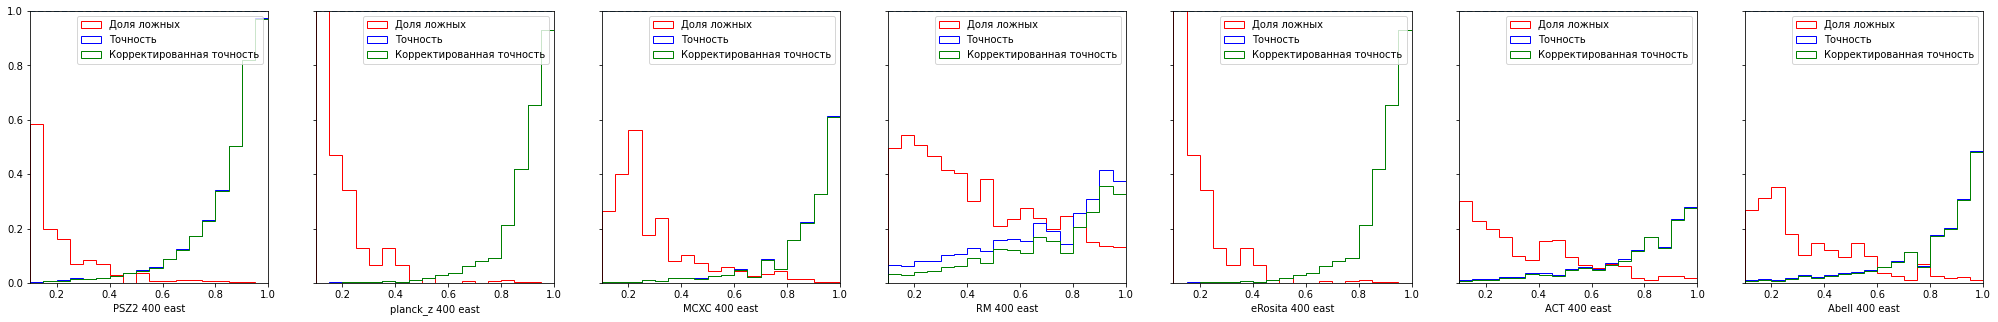

In [30]:
draw_histograms(400, 'east')

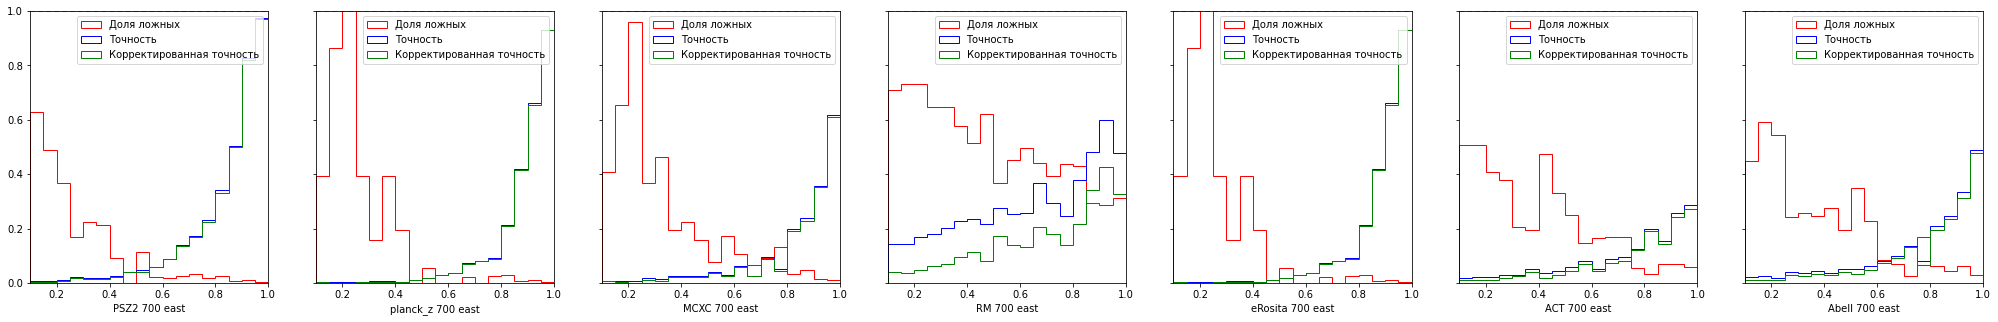

In [31]:
draw_histograms(700, 'east')

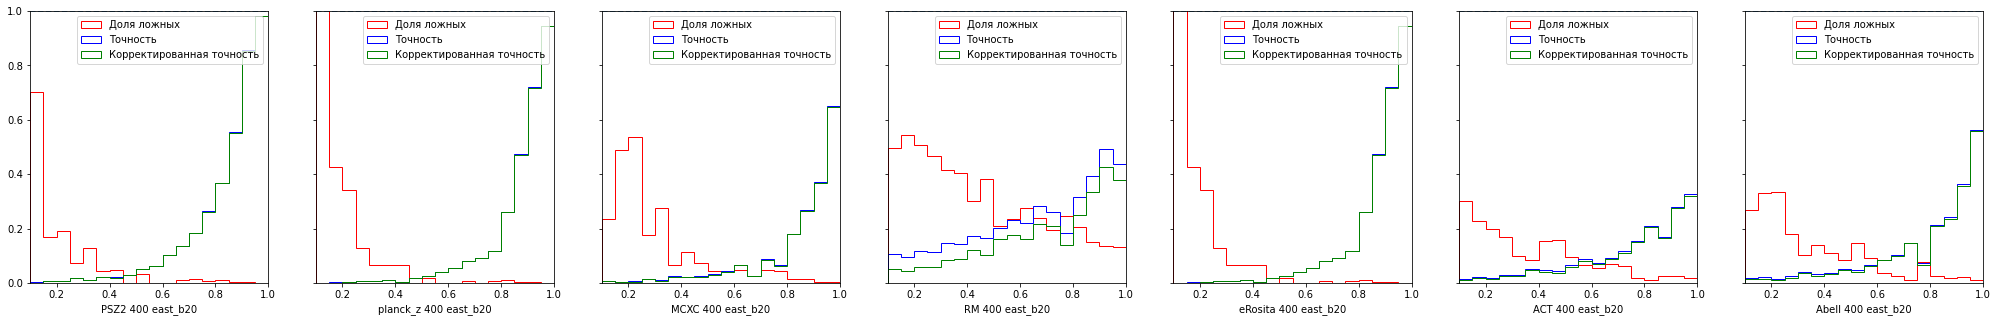

In [32]:
draw_histograms(400, 'east_b20')

In [14]:
def make_map_cat(cat, name, nside=2**6):
    df = pd.read_csv(cat)
    pix = radec2pix(df['RA'], df['DEC'], nside)
    a = np.zeros(hp.nside2npix(nside))
    a[pix] = 1
    hp.mollview(a, nest=True, title=name)

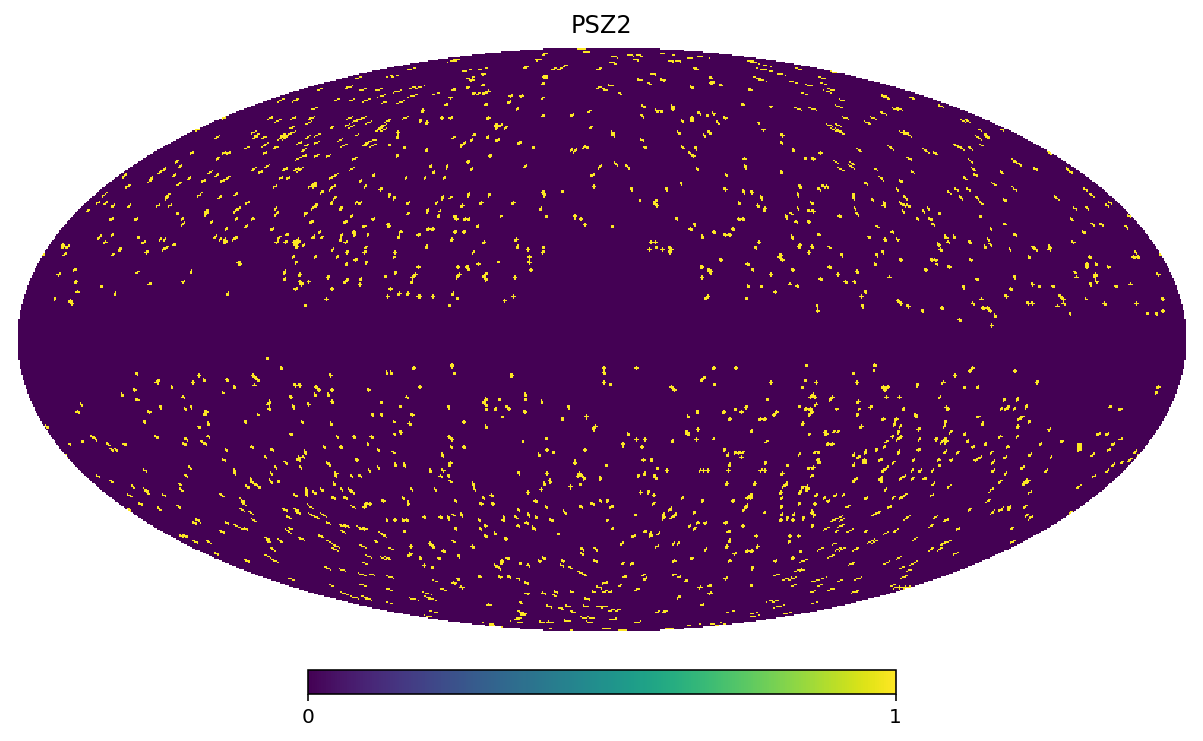

In [15]:
make_map_cat(true_cats['PSZ2'], 'PSZ2')

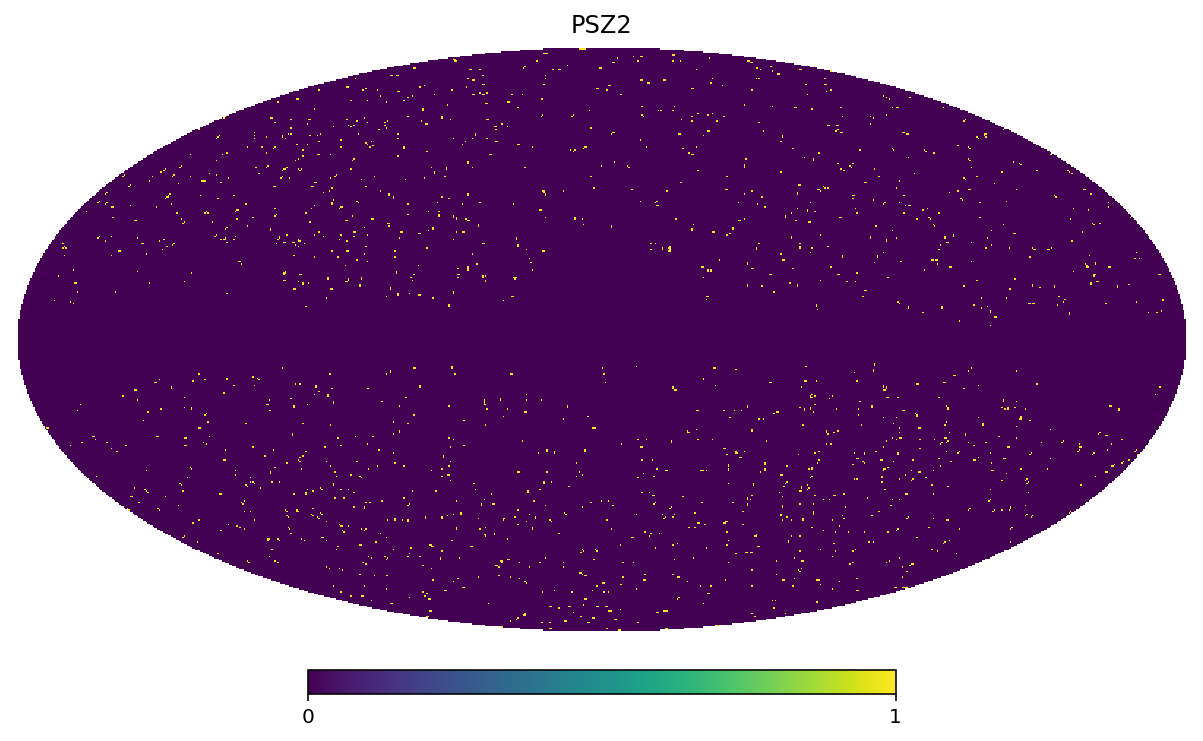

In [16]:
make_map_cat(true_cats['PSZ2'], 'PSZ2', nside=2**7)

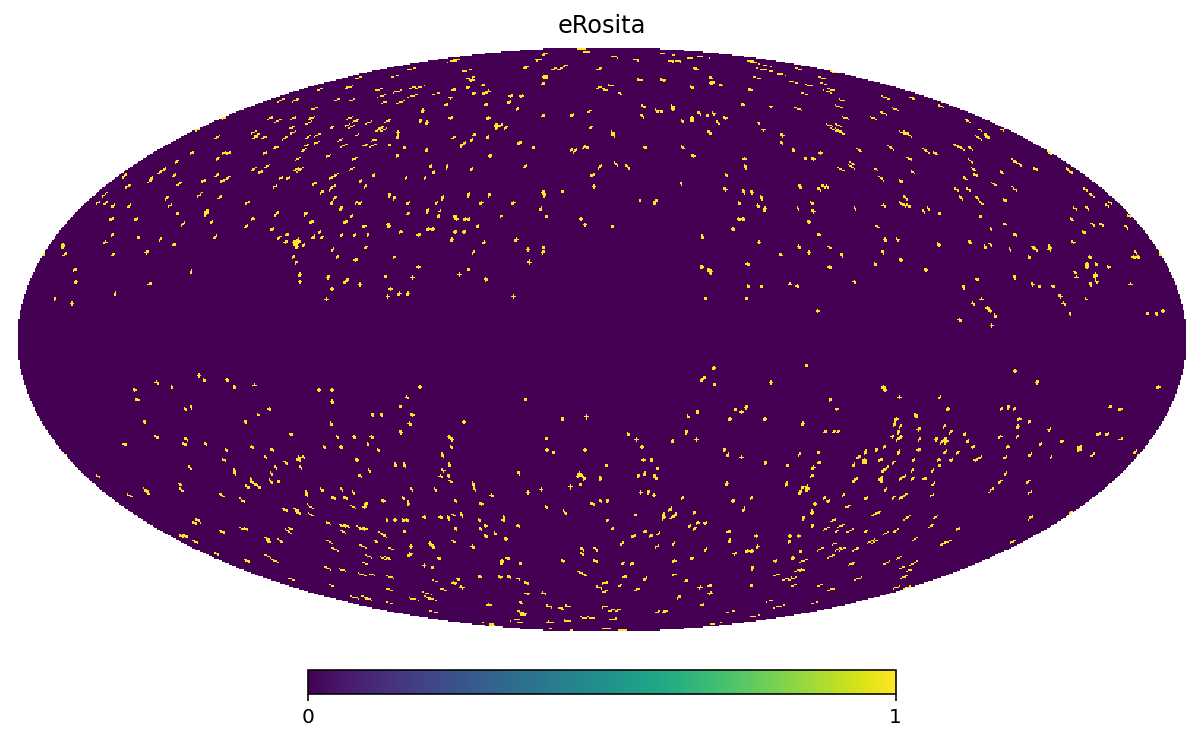

In [17]:
make_map_cat(true_cats['eRosita'], 'eRosita')

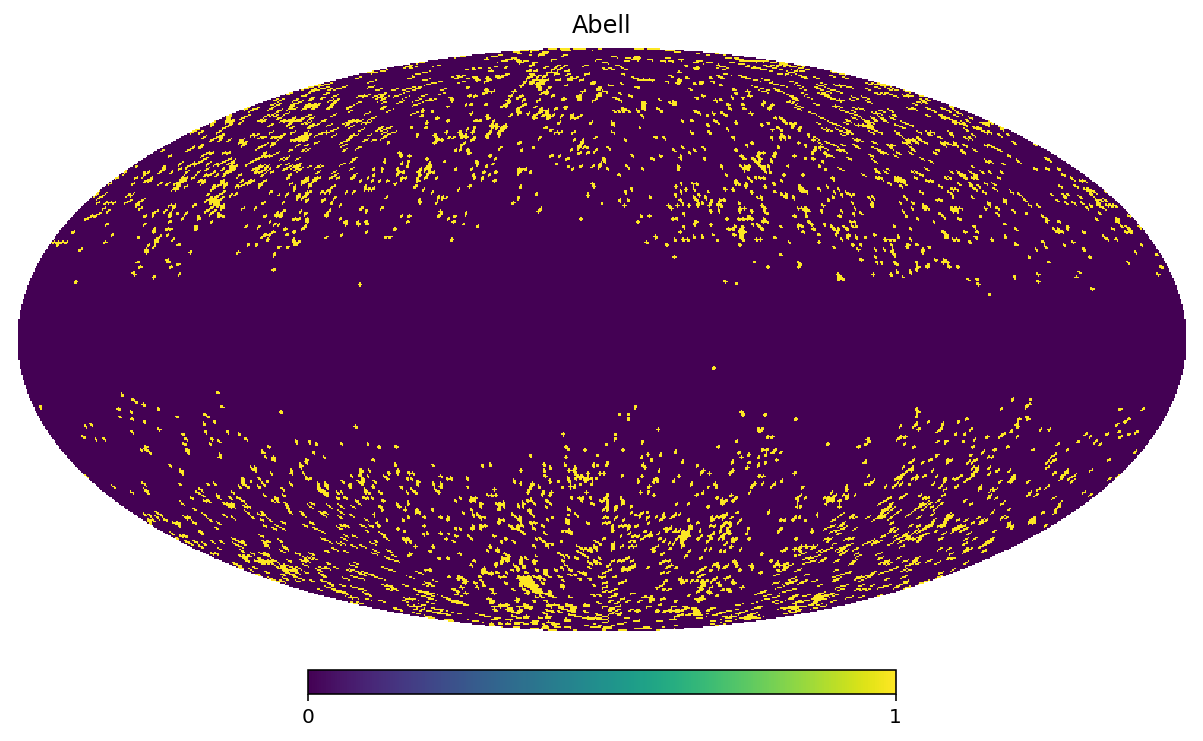

In [18]:
make_map_cat(true_cats['Abell'], 'Abell')